
# PPO Training (Multi-Valley Mountain Car, Shaped Reward)
Single-condition run: `dt=0.1`, `gamma=0.95`, with shaped reward for learning.


In [1]:

# If needed, install dependencies
# !pip install "stable-baselines3[extra]" gymnasium tqdm torch


In [2]:

from pathlib import Path
import sys
import torch

repo_root = Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))


In [3]:

from multi_valley_mountain_car_env import MultiValleyMountainCarEnv


In [4]:

import numpy as np
import gymnasium as gym


class ShapedRewardMVMWrapper(gym.Wrapper):
    """Energy-based reward shaping wrapper for MultiValleyMountainCarEnv.

    This wrapper does NOT terminate on success; base environment termination behavior
    remains unchanged.

    Shaped reward (only two terms):
    r = w_sparse * 1[goal] + w_energy * max(0, (E_t - E_{t-1}) / dt)
    where E_t = 0.5 * v_t^2 + h(x_t), and h(x) is env terrain height.
    """

    def __init__(self, env, w_sparse=5.0, w_energy=3.0):
        super().__init__(env)
        self.w_sparse = float(w_sparse)
        self.w_energy = float(w_energy)

        self._prev_energy = None

    def _energy(self, obs):
        x = float(obs[0])
        v = float(obs[1])
        h = float(self.env.unwrapped._height(np.array([x]))[0])
        return 0.5 * (v * v) + h

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._prev_energy = self._energy(obs)
        return obs, info

    def step(self, action):
        obs, base_reward, terminated, truncated, info = self.env.step(action)

        dt_env = float(getattr(self.env.unwrapped, 'dt', 1.0))
        dt_safe = max(dt_env, 1e-8)

        energy_now = self._energy(obs)
        energy_rate = 0.0
        if self._prev_energy is not None:
            energy_rate = (energy_now - self._prev_energy) / dt_safe
        energy_rate_pos = max(0.0, energy_rate)
        self._prev_energy = energy_now

        x_now = float(obs[0])
        uw = self.env.unwrapped
        on_goal = bool((uw.min_goal_position <= x_now) and (x_now <= uw.max_goal_position))

        shaped_reward = self.w_sparse * (1.0 if on_goal else 0.0) + self.w_energy * energy_rate_pos

        info = dict(info)
        info['base_reward'] = float(base_reward)
        info['shaped_reward'] = float(shaped_reward)
        info['energy'] = float(energy_now)
        info['energy_rate'] = float(energy_rate)
        info['energy_rate_pos'] = float(energy_rate_pos)

        return obs, float(shaped_reward), terminated, truncated, info


In [5]:

experiment_name = "ppo_mvmc_dt0p1_gamma095_shaped"
seed = 42

# Training budget
total_timesteps = 2_000_000

# Environment
dt = 0.1
n_envs = 8
max_episode_steps = 1000

# PPO
learning_rate = 3e-4
n_steps = 2048
batch_size = 256
gamma = 0.95
gae_lambda = 0.95
clip_range = 0.2
ent_coef = 0.05
vf_coef = 0.5
max_grad_norm = 0.5
target_kl = 0.03

# Energy-shaped reward parameters (only two terms)
shape_w_sparse = 5.0
shape_w_energy = 3.0

# Logging
log_every_rollout = 1

# In-training evaluation of G = sum_t gamma^(t*dt) * r_t * dt
# Set eval_every_rollouts=1 to show G each rollout in progress bar.
eval_every_rollouts = 1
eval_num_episodes_train = 2
eval_max_steps_train = 1000
eval_dt_env = dt

# For MLP PPO, CPU is usually faster/more stable than forcing GPU
device = "cpu"


In [6]:

import numpy as np
from datetime import datetime
import uuid
from tqdm.auto import tqdm
from gymnasium.wrappers import TimeLimit
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor


class TqdmStructuredLogger(BaseCallback):
    def __init__(
        self,
        total_timesteps,
        log_every_rollout=1,
        desc="Training",
        eval_env_fn=None,
        eval_gamma=None,
        eval_every_rollouts=1,
        eval_num_episodes=2,
        eval_max_steps=1000,
        verbose=0,
    ):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.log_every_rollout = log_every_rollout
        self.desc = desc

        self.eval_env_fn = eval_env_fn
        self.eval_gamma = eval_gamma
        self.eval_every_rollouts = eval_every_rollouts
        self.eval_num_episodes = eval_num_episodes
        self.eval_max_steps = eval_max_steps

        self._pbar = None
        self._last_timesteps = 0
        self._rollout_count = 0
        self.history = []
        self.eval_env = None

        self._last_G_mean = None
        self._last_G_std = None

    def _on_training_start(self):
        self._pbar = tqdm(
            total=self.total_timesteps,
            desc=self.desc,
            unit="ts",
            dynamic_ncols=True,
            leave=True,
        )
        self._last_timesteps = 0

        if self.eval_env_fn is not None:
            self.eval_env = self.eval_env_fn()

    def _on_step(self):
        if self._pbar is None:
            return True

        current = self.model.num_timesteps
        delta = current - self._last_timesteps
        if delta > 0:
            self._pbar.update(delta)
            self._last_timesteps = current
        return True

    @staticmethod
    def _play_episode(policy, env, gamma, num_steps=1000):
        obs, info = env.reset()
        reward_history = []
        dt_env = float(getattr(env.unwrapped, "dt", 1.0))

        for _ in range(num_steps):
            action, _ = policy.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            reward_history.append(float(reward))

            if terminated or truncated:
                break

        gamma_dt = gamma ** dt_env
        episode_return = 0.0
        for reward in reversed(reward_history):
            episode_return = gamma_dt * episode_return + reward * dt_env
        return episode_return

    def _evaluate_G(self):
        if self.eval_env is None or self.eval_gamma is None:
            return None, None

        return_history = []
        for _ in range(self.eval_num_episodes):
            episode_return = self._play_episode(
                self.model,
                self.eval_env,
                self.eval_gamma,
                num_steps=self.eval_max_steps,
            )
            return_history.append(episode_return)

        mean_return = float(np.mean(return_history))
        std_return = float(np.std(return_history))
        return mean_return, std_return

    def _on_rollout_end(self):
        self._rollout_count += 1
        if self._rollout_count % self.log_every_rollout != 0:
            return

        ep_rewards = [info["r"] for info in self.model.ep_info_buffer] if len(self.model.ep_info_buffer) > 0 else []
        ep_rew_mean = float(np.mean(ep_rewards)) if ep_rewards else None
        success_buffer = list(getattr(self.model, "ep_success_buffer", []))
        success_rate = float(np.mean(success_buffer)) if success_buffer else None

        name_to_value = getattr(self.model.logger, "name_to_value", {})

        def get_val(*keys):
            for key in keys:
                val = name_to_value.get(key, None)
                if val is None:
                    continue
                try:
                    return float(val)
                except (TypeError, ValueError):
                    return None
            return None

        if self.eval_env is not None and self.eval_every_rollouts > 0:
            if self._rollout_count % self.eval_every_rollouts == 0:
                self._last_G_mean, self._last_G_std = self._evaluate_G()

        record = {
            "timesteps": int(self.model.num_timesteps),
            "ep_rew_mean": ep_rew_mean,
            "success_rate": success_rate,
            "approx_kl": get_val("train/approx_kl"),
            "clip_frac": get_val("train/clip_fraction"),
            "value_loss": get_val("train/value_loss"),
            "entropy": get_val("train/entropy_loss"),
            "policy_loss": get_val("train/policy_loss", "train/policy_gradient_loss"),
            "lr": get_val("train/learning_rate"),
            "G_mean": self._last_G_mean,
            "G_std": self._last_G_std,
        }
        self.history.append(record)

        def fmt(val, fmt_spec):
            if val is None:
                return "NA"
            return f"{val:{fmt_spec}}"

        if self._pbar is not None:
            self._pbar.set_postfix(
                {
                    "G": fmt(record["G_mean"], ".4f"),
                    "Gstd": fmt(record["G_std"], ".4f"),
                    "rew": fmt(record["ep_rew_mean"], ".3f"),
                    "succ": fmt(record["success_rate"], ".3f"),
                    "kl": fmt(record["approx_kl"], ".3g"),
                    "clip": fmt(record["clip_frac"], ".3g"),
                    "v_loss": fmt(record["value_loss"], ".3g"),
                    "ent": fmt(record["entropy"], ".3g"),
                    "p_loss": fmt(record["policy_loss"], ".3g"),
                    "lr": fmt(record["lr"], ".3g"),
                }
            )

    def _on_training_end(self):
        if self.eval_env is not None:
            self.eval_env.close()
        if self._pbar is not None:
            self._pbar.close()


In [7]:

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
run_id = f"{experiment_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{uuid.uuid4().hex[:8]}"

env = make_vec_env(
    lambda: TimeLimit(
        ShapedRewardMVMWrapper(
            MultiValleyMountainCarEnv(dt=dt),
            w_sparse=shape_w_sparse,
            w_energy=shape_w_energy,
        ),
        max_episode_steps=max_episode_steps,
    ),
    n_envs=n_envs,
    seed=seed,
)
env = VecMonitor(env)

model = PPO(
    "MlpPolicy",
    env,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    target_kl=target_kl,
    verbose=0,
    seed=seed,
    device=device,
)

callback = TqdmStructuredLogger(
    total_timesteps=total_timesteps,
    log_every_rollout=log_every_rollout,
    desc=f"dt={dt:.1f}, gamma={gamma:.2f}, energy-shaped",
    eval_env_fn=lambda: ShapedRewardMVMWrapper(
        MultiValleyMountainCarEnv(dt=eval_dt_env, render_mode=None),
        w_sparse=shape_w_sparse,
        w_energy=shape_w_energy,
    ),
    eval_gamma=gamma,
    eval_every_rollouts=eval_every_rollouts,
    eval_num_episodes=eval_num_episodes_train,
    eval_max_steps=eval_max_steps_train,
)
model.learn(total_timesteps=total_timesteps, callback=callback)

model_path = models_dir / f"{run_id}_dt{dt:.1f}_gamma{gamma:.2f}_shaped.zip"
model.save(model_path)
env.close()

print(f"Saved model to: {model_path}")
print(f"Final training step: {model.num_timesteps}")


c:\Users\hassa\miniconda3\envs\pytorch\lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


dt=0.1, gamma=0.95, energy-shaped:   0%|          | 0/2000000 [00:00<?, ?ts/s]

Saved model to: models\ppo_mvmc_dt0p1_gamma095_shaped_20260222_230508_620540c9_dt0.1_gamma0.95_shaped.zip
Final training step: 2015232


In [8]:

# Optional: inspect the last few callback records
callback.history[-5:] if len(callback.history) >= 5 else callback.history


[{'timesteps': 1949696,
  'ep_rew_mean': 33.709938049316406,
  'success_rate': 0.04,
  'approx_kl': 0.002195242792367935,
  'clip_frac': 0.0114990234375,
  'value_loss': 0.048310976673383264,
  'entropy': -0.6513655824586749,
  'policy_loss': -0.0007871798199630576,
  'lr': 0.0003,
  'G_mean': 0.6979836644098986,
  'G_std': 0.020403956061397},
 {'timesteps': 1966080,
  'ep_rew_mean': 26.222505569458008,
  'success_rate': 0.03,
  'approx_kl': 0.0007720051798969507,
  'clip_frac': 0.000994873046875,
  'value_loss': 0.08559671560651623,
  'entropy': -0.6322089443914592,
  'policy_loss': 0.00020116470386710716,
  'lr': 0.0003,
  'G_mean': 1.8127401092842828,
  'G_std': 0.43661826810122406},
 {'timesteps': 1982464,
  'ep_rew_mean': 21.576383590698242,
  'success_rate': 0.02,
  'approx_kl': 0.0027528847567737103,
  'clip_frac': 9.765625e-05,
  'value_loss': 0.04657987291575409,
  'entropy': -0.6403062589466572,
  'policy_loss': 9.244975790352327e-05,
  'lr': 0.0003,
  'G_mean': 1.20453905697

In [9]:

# Standard evaluation method (fixed horizon, discounted integral return)
# This matches your preferred logic for every run.

eval_num_episodes = 10
eval_max_steps = 1000
eval_dt_env = dt
gamma_eval = gamma

# Use trained model if available, otherwise load from path.
manual_model_path = None
if manual_model_path is not None:
    eval_model = PPO.load(manual_model_path)
elif 'model' in globals():
    eval_model = model
elif 'model_path' in globals():
    eval_model = PPO.load(str(model_path))
else:
    raise RuntimeError('No trained model found. Run training cell or set manual_model_path.')


def play_episode(model, env, gamma, num_steps=1000):
    obs, info = env.reset(seed=seed)
    reward_history = []
    dt_env = float(getattr(env.unwrapped, 'dt', 1.0))

    for _ in range(num_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        reward_history.append(float(reward))

        # Safe with wrappers that may terminate/truncate.
        if terminated or truncated:
            break

    gamma_dt = gamma ** dt_env
    episode_return = 0.0
    for reward in reversed(reward_history):
        episode_return = gamma_dt * episode_return + reward * dt_env
    return episode_return


def evaluate_policy(model, env, gamma, num_steps=1000, num_episodes=10):
    return_history = []
    for _ in range(num_episodes):
        episode_return = play_episode(model, env, gamma, num_steps)
        return_history.append(episode_return)

    mean_return = float(np.mean(return_history))
    std_return = float(np.std(return_history))
    return mean_return, std_return, return_history


eval_env = ShapedRewardMVMWrapper(
    MultiValleyMountainCarEnv(dt=eval_dt_env, render_mode=None),
    w_sparse=shape_w_sparse,
    w_energy=shape_w_energy,
)
mean_return, std_return, return_history = evaluate_policy(
    eval_model,
    eval_env,
    gamma=gamma_eval,
    num_steps=eval_max_steps,
    num_episodes=eval_num_episodes,
)
eval_env.close()

print(
    f"Eval ({eval_num_episodes} eps, energy-shaped): dt_env={eval_dt_env:.1f}, gamma={gamma_eval:.2f}, "
    f"mean_return={mean_return:.4f}, std_return={std_return:.4f}"
)


Eval (10 eps, energy-shaped): dt_env=0.1, gamma=0.95, mean_return=1.0053, std_return=0.0000


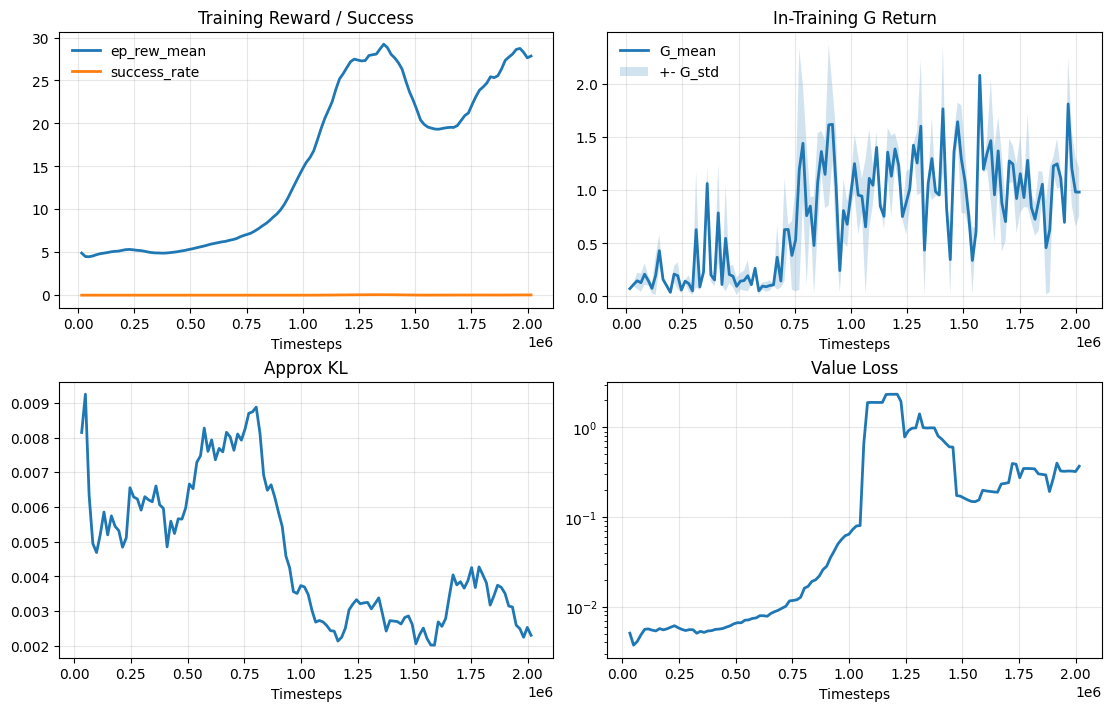

In [10]:

# Diagnostics plots after training
import numpy as np
import matplotlib.pyplot as plt

if 'callback' not in globals() or len(getattr(callback, 'history', [])) == 0:
    raise RuntimeError('No callback history found. Run training first.')

history = callback.history
timesteps = np.array([h.get('timesteps', np.nan) for h in history], dtype=float)

def arr(key):
    return np.array([
        np.nan if h.get(key, None) is None else float(h.get(key))
        for h in history
    ], dtype=float)


def moving_avg(x, w=10):
    x = np.asarray(x, dtype=float)
    if w <= 1:
        return x
    y = np.empty_like(x)
    for i in range(len(x)):
        lo = max(0, i - w + 1)
        v = x[lo:i+1]
        y[i] = np.nan if np.all(np.isnan(v)) else np.nanmean(v)
    return y

rew = moving_avg(arr('ep_rew_mean'), 10)
succ = moving_avg(arr('success_rate'), 10)
kl = moving_avg(arr('approx_kl'), 10)
vloss = moving_avg(arr('value_loss'), 10)
eval_mean = arr('G_mean')
eval_std = arr('G_std')

fig, ax = plt.subplots(2, 2, figsize=(11, 7), constrained_layout=True)

ax[0, 0].plot(timesteps, rew, label='ep_rew_mean', linewidth=2)
ax[0, 0].plot(timesteps, succ, label='success_rate', linewidth=2)
ax[0, 0].set_title('Training Reward / Success')
ax[0, 0].set_xlabel('Timesteps')
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend(frameon=False)

mask = ~np.isnan(eval_mean)
if np.any(mask):
    x = timesteps[mask]
    m = eval_mean[mask]
    s = eval_std[mask]
    ax[0, 1].plot(x, m, linewidth=2, label='G_mean')
    if np.any(~np.isnan(s)):
        s2 = np.nan_to_num(s, nan=0.0)
        ax[0, 1].fill_between(x, m - s2, m + s2, alpha=0.2, label='+- G_std')
else:
    ax[0, 1].text(0.5, 0.5, 'No in-training eval points', ha='center', va='center', transform=ax[0, 1].transAxes)
ax[0, 1].set_title('In-Training G Return')
ax[0, 1].set_xlabel('Timesteps')
ax[0, 1].grid(alpha=0.3)
ax[0, 1].legend(frameon=False)

ax[1, 0].plot(timesteps, kl, linewidth=2)
ax[1, 0].set_title('Approx KL')
ax[1, 0].set_xlabel('Timesteps')
ax[1, 0].grid(alpha=0.3)

ax[1, 1].plot(timesteps, vloss, linewidth=2)
ax[1, 1].set_title('Value Loss')
ax[1, 1].set_xlabel('Timesteps')
ax[1, 1].set_yscale('log')
ax[1, 1].grid(alpha=0.3)

plt.show()




Saved: plots\g_return_errorbar_dt0.1_gamma0.95_shaped.png
Saved: plots\g_return_errorbar_dt0.1_gamma0.95_shaped.pdf


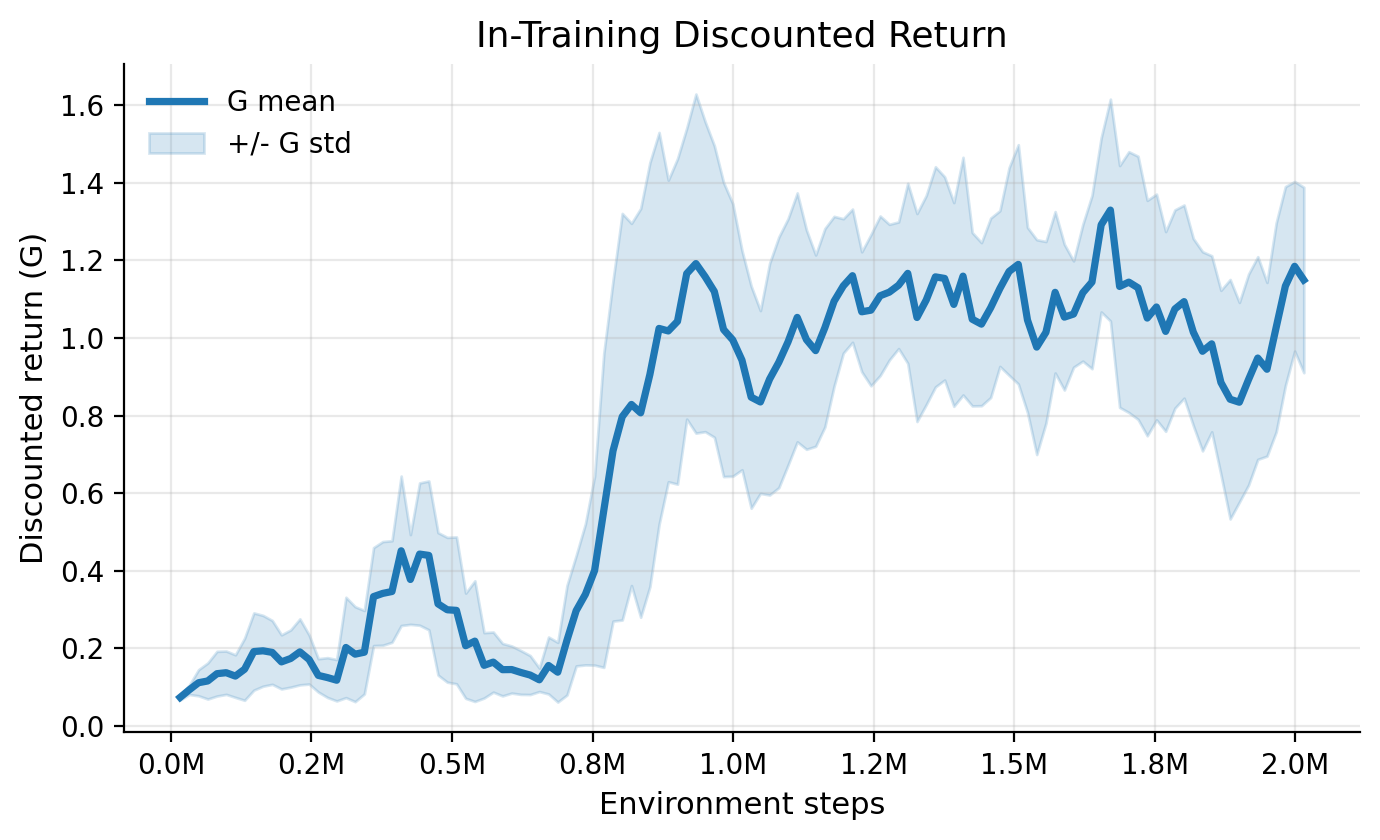

In [11]:

# Paper-ready plot: in-training discounted return G with uncertainty band
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

if 'callback' not in globals() or len(getattr(callback, 'history', [])) == 0:
    raise RuntimeError('No callback history found. Run training first.')

history = callback.history

timesteps = np.array([h.get('timesteps', np.nan) for h in history], dtype=float)
G_mean = np.array([
    np.nan if h.get('G_mean', None) is None else float(h.get('G_mean'))
    for h in history
], dtype=float)
G_std = np.array([
    np.nan if h.get('G_std', None) is None else float(h.get('G_std'))
    for h in history
], dtype=float)

mask = (~np.isnan(timesteps)) & (~np.isnan(G_mean))
if not np.any(mask):
    raise RuntimeError('No valid in-training G values to plot.')

x = timesteps[mask]
y = G_mean[mask]
s = np.nan_to_num(G_std[mask], nan=0.0)

# Light smoothing for publication readability
smooth_window = 7

def rolling_mean(arr, w):
    if w <= 1:
        return arr
    out = np.empty_like(arr)
    for i in range(len(arr)):
        lo = max(0, i - w + 1)
        out[i] = np.mean(arr[lo:i + 1])
    return out

y_s = rolling_mean(y, smooth_window)
s_s = rolling_mean(s, smooth_window)

fig, ax = plt.subplots(figsize=(7.0, 4.3), dpi=200)

line_color = '#1f77b4'
ax.plot(x, y_s, color=line_color, linewidth=2.6, label='G mean')
ax.fill_between(x, y_s - s_s, y_s + s_s, color=line_color, alpha=0.18, label='+/- G std')

ax.set_title('In-Training Discounted Return', fontsize=13)
ax.set_xlabel('Environment steps', fontsize=11)
ax.set_ylabel('Discounted return (G)', fontsize=11)
ax.grid(True, alpha=0.28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc='best')

ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v/1e6:.1f}M'))

plt.tight_layout()

out_dir = Path('plots')
out_dir.mkdir(parents=True, exist_ok=True)
stem = f'g_return_errorbar_dt{dt:.1f}_gamma{gamma:.2f}_shaped'
png_path = out_dir / f'{stem}.png'
pdf_path = out_dir / f'{stem}.pdf'
fig.savefig(png_path, dpi=400, bbox_inches='tight')
fig.savefig(pdf_path, bbox_inches='tight')

print(f'Saved: {png_path}')
print(f'Saved: {pdf_path}')
plt.show()
